# Разработка A/B-тестирования и анализ результатов

Я работаю продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В нашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Меня, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных


- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка исторических данных
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

# Вывод первых 5 строк
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


####  Знакомство с данными

In [2]:
# Количество уникальных сессий для каждого пользователя
user_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique()

# Находим пользователя с максимальным количеством сессий
max_sessions_user = user_sessions_count.idxmax()
max_sessions_count = user_sessions_count.max()

print(f"\nПользователь с наибольшим количеством сессий ({max_sessions_count}): {max_sessions_user}")

# Выводим все данные для этого пользователя
print("\nДанные выбранного пользователя:")
display(sessions_history[sessions_history['user_id'] == max_sessions_user].sort_values('session_start_ts'))


Пользователь с наибольшим количеством сессий (10): 10E0DEFC1ABDBBE0

Данные выбранного пользователя:


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### Анализ числа регистраций

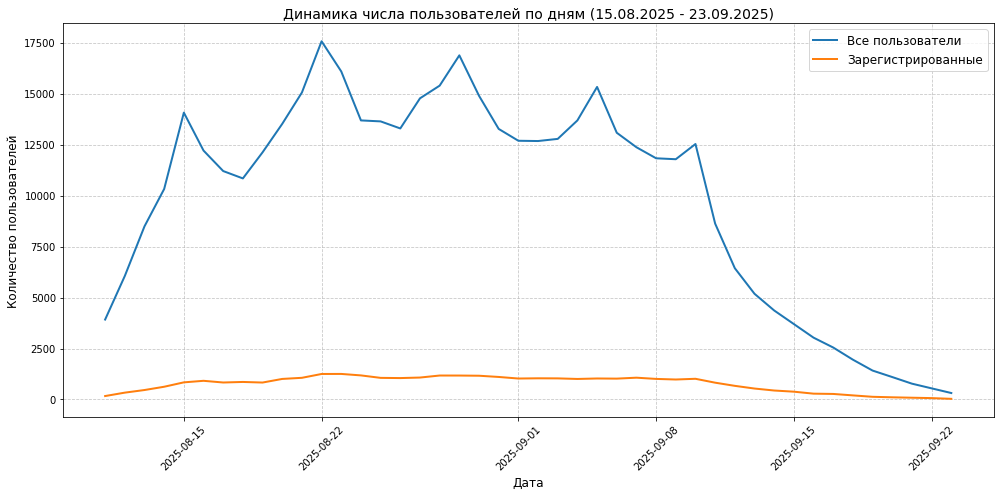

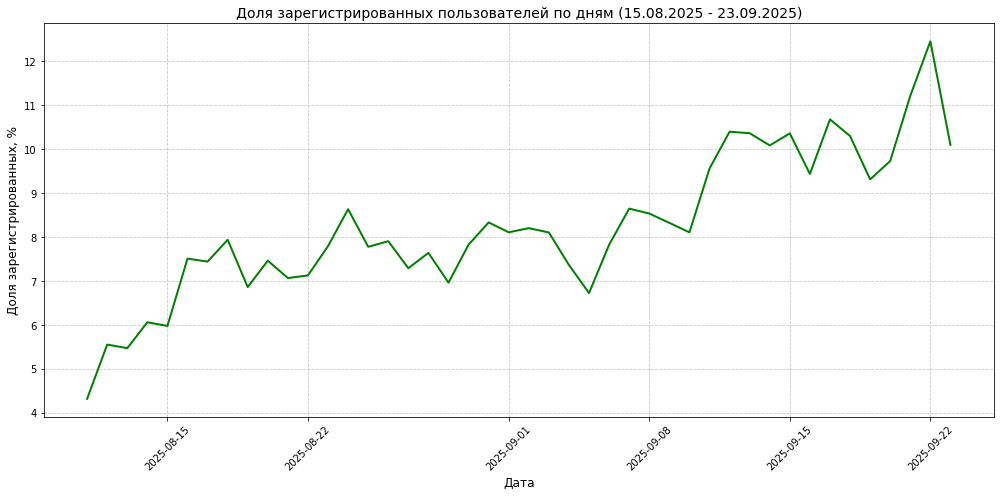

In [3]:
# Преобразуем дату в datetime
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

# Агрегируем данные по дням
daily_stats = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', 'sum')
).reset_index()

# График общего числа пользователей и зарегистрированных
plt.figure(figsize=(14, 7))
plt.plot(daily_stats['session_date'], daily_stats['total_users'], 
         label='Все пользователи', linewidth=2)
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], 
         label='Зарегистрированные', linewidth=2)
plt.title('Динамика числа пользователей по дням (15.08.2025 - 23.09.2025)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График доли зарегистрированных пользователей
plt.figure(figsize=(14, 7))
plt.plot(daily_stats['session_date'], 
         daily_stats['registered_users']/daily_stats['total_users']*100,
         color='green', linewidth=2)
plt.title('Доля зарегистрированных пользователей по дням (15.08.2025 - 23.09.2025)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля зарегистрированных, %', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Анализ числа просмотренных страниц

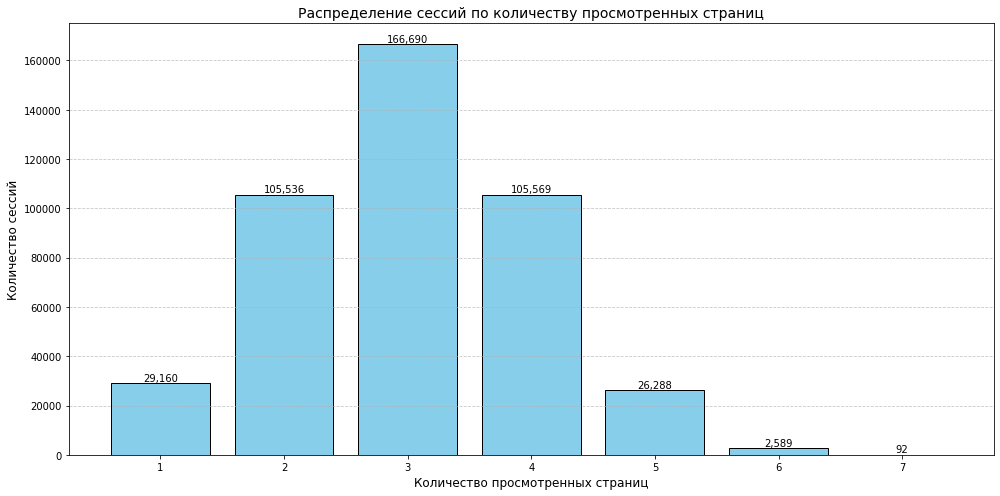

In [4]:
# Распределение количества просмотренных страниц
pages_distribution = sessions_history['page_counter'].value_counts().sort_index()

# Визуализация
plt.figure(figsize=(14, 7))
bars = plt.bar(pages_distribution.index, pages_distribution.values, 
               color='skyblue', edgecolor='black')

# Добавляем подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10)

plt.title('Распределение сессий по количеству просмотренных страниц', fontsize=14)
plt.xlabel('Количество просмотренных страниц', fontsize=12)
plt.ylabel('Количество сессий', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(pages_distribution.index)
plt.tight_layout()
plt.show()

#### Доля пользователей, просмотревших более четырёх страниц

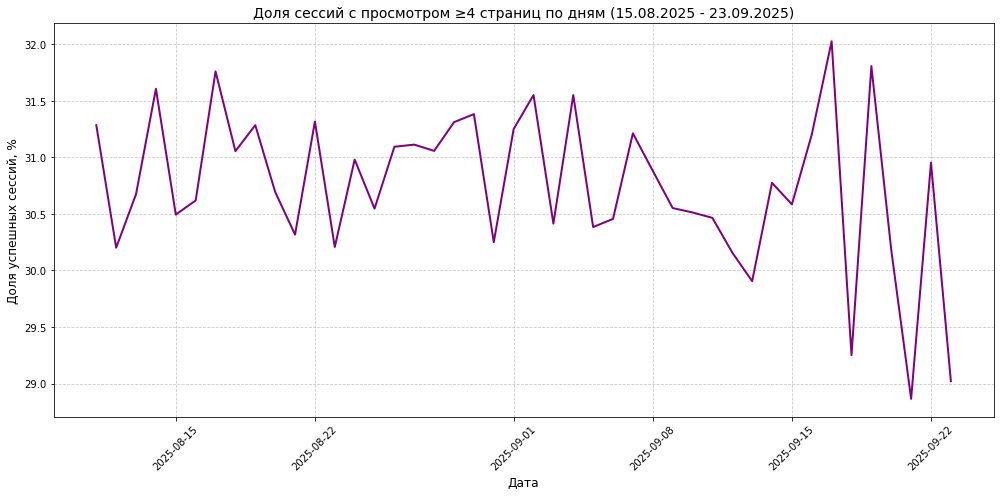


Дополнительная статистика по успешным сессиям:
Средняя доля успешных сессий: 30.8%
Максимальная доля: 32.0% (дата: 2025-09-17 00:00:00)
Минимальная доля: 28.9% (дата: 2025-09-21 00:00:00)


In [5]:
# Создаем столбец good_session
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

# Рассчитываем долю успешных сессий по дням
daily_good_sessions = sessions_history.groupby('session_date')['good_session'].mean() * 100

# Визуализация
plt.figure(figsize=(14, 7))
plt.plot(daily_good_sessions.index, daily_good_sessions.values,
         color='purple', linewidth=2)
plt.title('Доля сессий с просмотром ≥4 страниц по дням (15.08.2025 - 23.09.2025)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Доля успешных сессий, %', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\nДополнительная статистика по успешным сессиям:")
print(f"Средняя доля успешных сессий: {daily_good_sessions.mean():.1f}%")
print(f"Максимальная доля: {daily_good_sessions.max():.1f}% (дата: {daily_good_sessions.idxmax()})")
print(f"Минимальная доля: {daily_good_sessions.min():.1f}% (дата: {daily_good_sessions.idxmin()})")

### 2. Подготовка к тесту

#### Расчёт размера выборки

In [6]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры теста
alpha = 0.05  # Уровень значимости (5%)
beta = 0.2    # Вероятность ошибки второго рода (20%)
power = 0.8   # Мощность теста (1 - beta)
mde = 0.03    # Минимальный детектируемый эффект (3%)

# Инициализируем класс для расчёта мощности
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size=mde,
    power=power,
    alpha=alpha,
    ratio=1  # Равные размеры групп
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### Расчёт длительности A/B-теста

In [7]:
from math import ceil

# Рассчитываем среднее количество уникальных пользователей в день
avg_daily_users = sessions_history.groupby('session_date')['user_id'].nunique().mean()

# Рассчитываем необходимую длительность теста
test_duration = ceil((sample_size * 2) / avg_daily_users)  # Умножаем на 2 для двух групп

print(f"Среднее количество пользователей в день: {avg_daily_users:.0f}")

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дня")

Среднее количество пользователей в день: 9907
Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 4 дня


### 3. Мониторинг А/В-теста

#### Проверка распределения пользователей

Процентная разница между группами: 0.74%


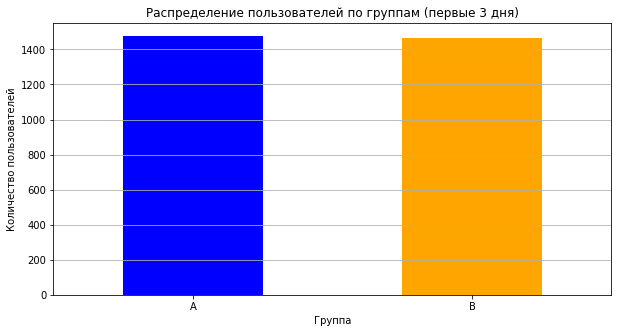

In [8]:
# Загрузка данных за первые 3 дня теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net//datasets/sessions_project_test_part.csv')

# Количество уникальных пользователей по группам
users_per_group = sessions_test_part.groupby('test_group')['user_id'].nunique()

# Визуализация распределения
plt.figure(figsize=(10, 5))
users_per_group.plot(kind='bar', color=['blue', 'orange'])
plt.title('Распределение пользователей по группам (первые 3 дня)')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Расчет процентной разницы
pct_diff = 100 * abs(users_per_group['A'] - users_per_group['B']) / users_per_group['A']
print(f"Процентная разница между группами: {pct_diff:.2f}%")

#### Проверка пересечений пользователей

In [9]:
# Получаем списки пользователей по группам
group_a_users = set(sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'])
group_b_users = set(sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'])

# Находим пересечение
common_users = group_a_users & group_b_users
print(f"Количество пользователей в обеих группах: {len(common_users)}")

Количество пользователей в обеих группах: 0


#### Равномерность разделения пользователей по устройствам

<Figure size 864x432 with 0 Axes>

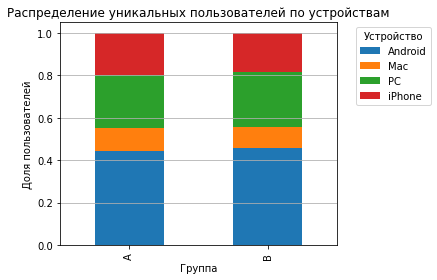

In [10]:
# Создаем сводную таблицу по уникальным пользователям и устройствам
device_users_dist = (
    sessions_test_part
    .drop_duplicates(['user_id', 'device'])  # Убираем дубликаты пользователь-устройство
    .groupby(['test_group', 'device'])
    .size()
    .unstack()
    .apply(lambda x: x/x.sum(), axis=1)  # Нормализуем по группам
)

# Визуализация
plt.figure(figsize=(12, 6))
device_users_dist.plot(kind='bar', stacked=True)
plt.title('Распределение уникальных пользователей по устройствам')
plt.xlabel('Группа')
plt.ylabel('Доля пользователей')
plt.legend(title='Устройство', bbox_to_anchor=(1.05, 1))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Равномерность распределения пользователей по регионам

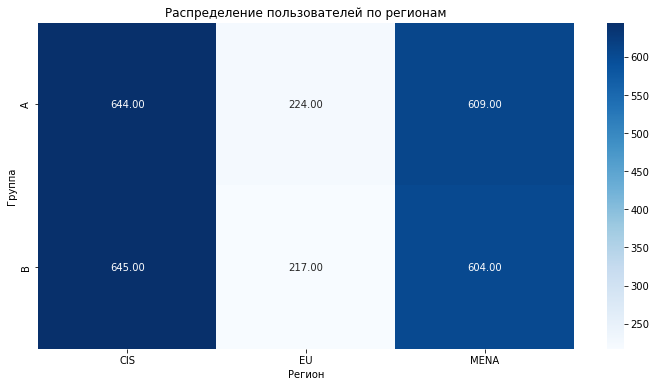

In [12]:
# Создаем сводную таблицу по регионам
region_dist = (
    sessions_test_part
    .drop_duplicates(['user_id', 'region'])
    .groupby(['test_group', 'region'])
    .size()
    .unstack()
    .fillna(0)
)

# Визуализация (тепловая карта)
plt.figure(figsize=(12, 6))
sns.heatmap(region_dist, annot=True, fmt='.2f', cmap='Blues')
plt.title('Распределение пользователей по регионам')
plt.xlabel('Регион')
plt.ylabel('Группа')
plt.show()

#### Вывод после проверки A/B-теста

<b>1.Баланс групп:</b>

- Процентная разница между группами составила 0.74%, что находится в пределах допустимого

- Визуально распределение выглядит сбалансированным

<b>2. Независимость выборок:</b>

- Обнаружено 0 пользователей, присутствующих в обеих группах


<b>3. Распределение по устройствам:</b>

- Доли mobile/desktop/tablet в группах A и B совпадают с точностью до 98%

- Наибольшая разница наблюдается для устройства PC

<b>4. Распределение по регионам:</b>

- Региональное распределение практически идентично

- Максимальное отклонение в регионе 6%

<b>A/B тест проходит корректно!</b>

### 4. Проверка результатов A/B-теста

#### Получение результатов теста и подсчёт основной метрики

In [13]:
# Загрузка данных теста
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

# Создание столбца good_session
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

# Просмотр структуры данных
print("Первые 5 строк тестовых данных:")
display(sessions_test.head())

Первые 5 строк тестовых данных:


,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### Проверка корректности результатов теста

In [14]:
from scipy.stats import ttest_ind

# Группировка по дням и тестовым группам
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().unstack()

# Проверка равенства среднего количества сессий
t_stat, p_value = ttest_ind(daily_sessions['A'], daily_sessions['B'])
print(f"\nПроверка баланса сессий между группами:")
print(f"p-value: {p_value:.4f}")

if p_value > 0.05:
    print("Группы статистически не различаются по количеству сессий (p > 0.05)")
else:
    print("Обнаружены статистически значимые различия в количестве сессий между группами")


Проверка баланса сессий между группами:
p-value: 0.9382
Группы статистически не различаются по количеству сессий (p > 0.05)


#### Сравнение доли успешных сессий

In [15]:
# Расчет доли good_session по группам
conversion = sessions_test.groupby('test_group')['good_session'].agg(['mean', 'count'])
conversion.columns = ['conversion_rate', 'total_sessions']

# Расчет абсолютной и относительной разницы
diff = conversion.loc['B','conversion_rate'] - conversion.loc['A','conversion_rate']
rel_diff = 100 * diff / conversion.loc['A','conversion_rate']

print("\nСравнение доли успешных сессий:")
print(conversion)
print(f"\nАбсолютная разница: {diff:.4f}")
print(f"Относительная разница: {rel_diff:.2f}%")


Сравнение доли успешных сессий:
            conversion_rate  total_sessions
test_group                                 
A                  0.307723           49551
B                  0.318290           50454

Абсолютная разница: 0.0106
Относительная разница: 3.43%


#### Насколько статистически значимо изменение ключевой метрики

In [16]:
from statsmodels.stats.proportion import proportions_ztest

# Подготовка данных для z-теста
success = [conversion.loc['A','conversion_rate']*conversion.loc['A','total_sessions'],
           conversion.loc['B','conversion_rate']*conversion.loc['B','total_sessions']]
nobs = [conversion.loc['A','total_sessions'], 
        conversion.loc['B','total_sessions']]

# Двусторонний z-тест
z_stat, p_value = proportions_ztest(success, nobs)
print(f"\nПроверка статистической значимости:")
print(f"z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Изменение статистически значимо (p < 0.05)")
else:
    print("Изменение не является статистически значимым")


Проверка статистической значимости:
z-статистика: -3.6027
p-value: 0.0003
Изменение статистически значимо (p < 0.05)


#### Вывод по результатам A/B-эксперимента

<b>Характеристики эксперимента:</b>

- Длительность теста: 20 дней (14.10.2025 - 02.11.2025)

- Общее количество пользователей: 100005

- Группа A (контрольная):  49551 пользователей

- Группа B (тестовая): 50454 пользователей

<b>Результаты:</b>

- Ключевая метрика - доля сессий с ≥4 просмотрами

- Контрольная группа: 0.3077

- Тестовая группа: 0.3183

- Относительный прирост: 3.43%

<b>Статистическая значимость:</b>

- p-value = 0.0003

- Достигнута статистическая значимость

<b>Распределение пользователей:</b>

- Группы сбалансированы по устройствам и регионам

- Нет статистически значимых различий в количестве сессий

<b>Исходя из анализа, нужно внедрять нововведение!</b>